# THIS IS SCRATCH
For the updated version of this code, go to lib/SLM_building.py, it has been trasnferred to a script

In [1]:
import numpy as np
import csv as csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math
import json
from datetime import datetime
from termcolor import colored
import os
from sklearn.model_selection import train_test_split
from langdetect import detect
import random
import seaborn as sns


from nltk.util import bigrams, ngrams
from nltk.lm.preprocessing import pad_both_ends, flatten, padded_everygram_pipeline
from nltk.lm.smoothing import GoodTuring
from nltk.tokenize import word_tokenize
from nltk.lm.models import InterpolatedLanguageModel, WittenBellInterpolated, KneserNeyInterpolated, MLE, Laplace
from nltk.lm.api import LanguageModel
from nltk.lm import NgramCounter

os.chdir('../data/')

MONTHS = list(range(1,13))



# SLM building functions
How different (in terms of cross-entrop) are posts from users within and outside a community?
Based on no country and Justine's later paper, right now we will look at, within a certian month, 

Follow this: 
    
- randomly sampling 200 active users—defined as users with at least 5 comments in the respective community and month.

- For each of these 200 active users we select 5 random 10-word spans from 5 unique comments.

- To ensure robustness and maximize data efficiency, we construct 100 SLMs for each community-month pair that
has enough data, bootstrap-resampling (resampling with replacement) from the set of active users.

In [2]:
##################################################################
# randomly sampling 200 users  
# defined as users with at least 5 COMMENTS ONLY in the respective community and month.
##################################################################
def get_active_users(author_df, month, author_col, threshold=5, num_authors=200):
    if num_authors: 
        return author_df[author_df[month] > threshold].drop_duplicates().sample(num_authors)[author_col]
    else: 
        return author_df[author_df[month] > threshold].drop_duplicates()[author_col]
    
##################################################################   
# For each of these 200 active users
# select 5 random 10-word spans from 5 unique comments
# ASSUMING: from that month
# ASSUMING: this is one 10 word span from each comment, not 5 for each comment
##################################################################
def get_random_span(text, length):
    text = [w.lower() for w in word_tokenize(text)][:length]
    return text 


##################################################################
# To ensure robustness and maximize data efficiency, 
# we construct 100 SLMs for each community-month pair that has enough data
##################################################################
def construct_LM(text, vocab=None):
    if vocab:
        train, _ =  padded_everygram_pipeline(2, text)
    else: 
        train, vocab =  padded_everygram_pipeline(2, text)
    lm = Laplace(2)
    lm.fit(train, vocab)
    return lm


##################################################################
# Alternative function for buidling SRILM LMs
# using bach scripts
##################################################################
# get some useful paths
def construct_SRILM_LM(text, vocab=None, 
                       srilm_bin_path='../../../tools/SRILM/bin/i686-m64/',
                       corpus_path='../data/srilm_data/',
                       lm_path='../srilms_LMs/',
                       lm_counts_path='../srilms_LMs/counts/'):
    
    # get all commands for constructing the 
    ngram_count_command = './' +SRILM_BIN_PATH + 'ngram-count'
    corpus = CORPUS_PATH + 'BB_text.txt'
    count = LM_COUNTS_PATH + 'BB_counts.count'
    lm = LM_OUTPUT_PATH + 'BB_lm.lm'
    lm = Laplace(2)
    lm.fit(train, vocab)
    return lm

# returns dict of {month:SLM}
def build_monthly_SLM(df, author_counts, slm_count):
    slm_dict = {}
    for m in MONTHS:
        print('Creating ', colored(str(slm_count) + ' SLMs ', 'red'), 'for', colored(' month ' + str(m), 'green'), '.....', end=' ')
        slms = []
        for i in range(1, slm_count + 1):
            active_users = get_active_users(author_counts, str(m), 'author')
            active_user_comments = get_user_comments(df, list(active_users), month=m, num_posts=5)
            slm = construct_LM(active_user_comments)
            slms.append(slm)
        slm_dict[m] = slms
        print('Done')
    return slm_dict



# Acculturation Gap functions

We compute a basic measure of the acculturation gap for a community-month
relative difference of the cross-entropy of comments by users active in
singleton comments by are still activein Reddit in general

For each bootstrap-sampled SLM we compute the cross-entropy of
50 comments by active users (10 comments from 5 randomly sampled active users, who
were not used to construct the SLM) and 50 comments from randomly-sampled outsiders.

Acc gap for a specific month is exp_value of outsiders - exp_value of active users / exp_value of active users 

In [3]:
##################################################################
# getting outsiders -- users who only ever posted once in a community-- 
# but are still activein Reddit in general  (TODO)
##################################################################
def get_outside_users(author_df, month, author_col, threshold=1, num_authors=None):
    outside_users = author_df[author_df[[str(m) for m in MONTHS]].sum(axis=1) <= threshold]
    if num_authors:
        return outside_users[outside_users[month] == threshold][author_col].sample(num_authors)
    else: 
        return outside_users[outside_users[month] == threshold][author_col]

##################################################################
# get 50 comments by active users (10 comments from 5 randomly sampled active users, 
# who were not used to construct the SLM -TODO) and 50 comments from randomly-sampled outsiders
# same length controlling effects used here - select random 10 word span from each comment (see ASSUMING above)
##################################################################
def get_user_comments(df, authors, month, num_posts, month_col='created_month'):
    df_month = df[df[month_col] == month]
    df_month_author = df_month[df_month['author'].apply(lambda x: x in authors)]
    df_grouped = df_month_author.groupby('author')
    sampled_comments = []
    for a, g in df_grouped:
        sample = g.sample(num_posts)['body'].apply(lambda x: get_random_span(x, 10))
        sampled_comments.extend(sample)
    return sampled_comments

###################################################################
# Acc gap for a specific month is 
# exp_value of outsiders - exp_value of active users / exp_value of active users
# ASSUMING: Expected value in this case is just a mean, since each likelihood is equally possible
# ISSUE: some spans are < 10
##################################################################

# wrapper function for possibly doing something else than just calculcating entropy
def check_ent(slm, text):
    ent = slm.entropy(text)
    return ent


def calc_month_acc_gap(slms_month_dict, month, text):
    slms = slms_month_dict[month]
    entropies = []
    text_bigrams = [list(ngrams(sent, 2, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='</s>')) for sent in text]
    for slm in slms:
        slm_entropies = list(map(lambda x: check_ent(slm, x), text_bigrams))
        entropies.append(slm_entropies)
    return entropies
  
def calc_acc_gap(slms, author_counts, comments):
    monthly_acc_gap = {}
    for month in slms.keys():
        print('Calculating cross entropy for', colored('month ' + str(month), 'green'), '.....')
        active_authors = get_active_users(author_counts, str(month), 'author', threshold=10, num_authors=5)
        outside_authors = get_outside_users(author_counts, str(month), 'author', threshold=1, num_authors=50)
        print('sampled active users:', len(active_authors), 'sampled outside users:', len(outside_authors))

        active_comments = get_user_comments(comments, list(active_authors), month=month, num_posts=10)
        outside_comments = get_user_comments(comments, list(outside_authors), month=month, num_posts=1)
        print('sampled active comments:', len(active_comments), 'sampled outside comments:', len(outside_comments))
        
        active_ent = list(flatten(calc_month_acc_gap(slms, month=month, text=active_comments)))
        outside_ent = list(flatten(calc_month_acc_gap(slms, month=month, text=outside_comments)))
        
        # calculate the acc gap
        exp_val_active_ent = np.mean(active_ent)
        exp_val_outside_ent = np.mean(outside_ent)
        acc_gap_month = (exp_val_outside_ent - exp_val_active_ent) / exp_val_active_ent
        
        # also save variance of the acc gap by subtracting: https://www.kean.edu/~fosborne/bstat/05b2means.html
        var_active_ent = np.var(active_ent)
        var_outside_ent = np.var(outside_ent)
        acc_gap_var = (var_active_ent/len(active_ent)) + (var_outside_ent/len(outside_ent))
        
        monthly_acc_gap[month] = {}
        monthly_acc_gap[month]['gap'] = acc_gap_month
        monthly_acc_gap[month]['var'] = acc_gap_var
        
        
        print('Saving acc gap for', colored('month ' + str(month), 'green'))
    return monthly_acc_gap
       

# Build SLMs and calculate Acculturation Gap
Using all the functions above to actually calculate and plot the acculturaion gaps
Import different clened csvs of data representing comments of different subs

In [5]:
###################################################################
# Importing data
###################################################################


def import_csvs(sub, path='cleaned/train/2017/', ext='_train_2017.csv'):
    
    # currently importing the same comments file for test/train
    # This is because the authors have been seperated, so there shouldn't be any of the same messages
    # between the two sets (even though they pull text from the same file)
    comment_path = 'cleaned/sub_comments/'+sub+'_comments_2017.csv'
    
    author_path = path+'author_counts/'+sub+'_author_counts'+ext
    
    print('Importing ', colored(comment_path, 'magenta'),'.....', end=' ')
    df_sub_comments = pd.read_csv(comment_path)
    print('Done')
    print('Importing ', colored(author_path, 'magenta'),'.....', end=' ')
    df_author_counts = pd.read_csv(author_path)
    print('Done')
    
    # renaming month columns per the issue of having a string float
    df_author_counts = df_author_counts.rename(index=str, columns={c:str(int(float(c))) for c in df_author_counts.columns.tolist()[2:]})
    
    return df_sub_comments, df_author_counts



-----------------------------------------------
Acculturation Gap for  Naruto
-----------------------------------------------
Importing  cleaned/sub_comments/Naruto_comments_2017.csv ..... Done
Importing  cleaned/train/2017/author_counts/Naruto_author_counts_train_2017.csv ..... Done
Importing  cleaned/sub_comments/Naruto_comments_2017.csv ..... Done
Importing  cleaned/test/2017/author_counts/Naruto_author_counts_test_2017.csv ..... Done
Creating  1 SLMs  for  month 1 ..... Done
Creating  1 SLMs  for  month 2 ..... Done
Creating  1 SLMs  for  month 3 ..... Done
Creating  1 SLMs  for  month 4 ..... Done
Creating  1 SLMs  for  month 5 ..... Done
Creating  1 SLMs  for  month 6 ..... Done
Creating  1 SLMs  for  month 7 ..... Done
Creating  1 SLMs  for  month 8 ..... Done
Creating  1 SLMs  for  month 9 ..... Done
Creating  1 SLMs  for  month 10 ..... Done
Creating  1 SLMs  for  month 11 ..... Done
Creating  1 SLMs  for  month 12 ..... Done
Calculating cross entropy for month 1 .....
sampled

KeyboardInterrupt: 

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


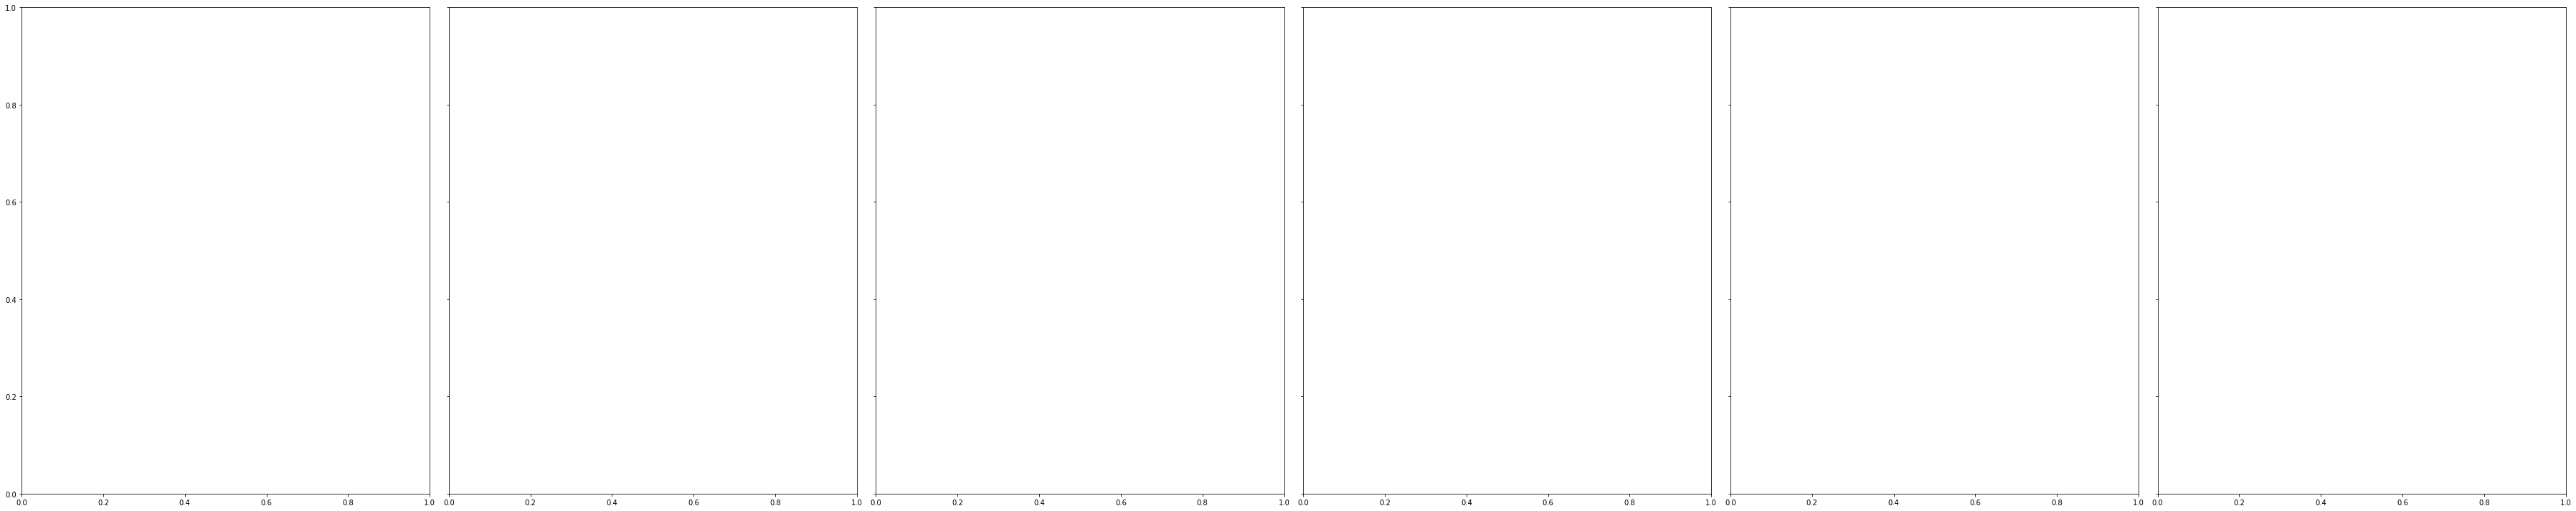

In [7]:
subs = ['Naruto', 'pics', 'BabyBumps', 'science', 'politics', 'Cooking']

fig, axs = plt.subplots(1, len(subs), sharey=True, tight_layout=True)
fig.set_figheight(10)
fig.set_figwidth(50)
subs_acc = {}
for i, s in enumerate(subs):
    print('-----------------------------------------------')
    print('Acculturation Gap for ', colored(s, 'magenta'))
    print('-----------------------------------------------')

    df_comments, df_author_counts_train = import_csvs(s)
    _, df_author_counts_test = import_csvs(s, path='cleaned/test/2017/', ext='_test_2017.csv')
    
    slms = build_monthly_SLM(df_comments, df_author_counts_train, 1)
    
    monthly_acc_gaps = calc_acc_gap(slms, df_author_counts_test, df_comments)
    
    subs_acc[s] = monthly_acc_gaps
    
    sns.lineplot(x=list(monthly_acc_gaps.keys()), y=[x['gap'] for x in monthly_acc_gaps.values()], ax=axs[i])
    axs[i].set_title('Acculturation Gap for ' + s, fontsize=30)
    axs[i].set_xlabel('Month', fontsize=30)
    axs[i].set_ylabel('Gap (Higher = more different)')
    axs[i].tick_params(axis='both', which='major', labelsize=25)
    
# fig.savefig('../tmp/naruto_acc_gap')

0.002137977006358201 0.014684833354669044
0.009469041515134552 0.01415816132406209
0.00999698218314796 0.017529256161958186
0.02311127267143299 0.01651770335256657
0.011702509963343039 0.01593037870768593
0.002823973402729057 0.013579488926012595


Text(0, 0.5, 'Gap')

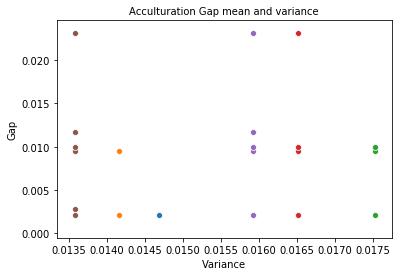

In [63]:

gaps = []
variances = []
for sub in subs_acc.keys():
    gap = np.mean([subs_acc[sub][m]['gap'] for m in range(1,13)])
    var = np.mean([subs_acc[sub][m]['var'] for m in range(1,13)])
    print(gap, var)
    gaps.append(gap)
    variances.append(var)
ax = sns.scatterplot(x=var, y=gaps)
    
ax.set_title('Acculturation Gap mean and variance', fontsize=10)
ax.set_xlabel('Variance', fontsize=10)
ax.set_ylabel('Gap')


In [9]:
df_author_counts_test

,Unnamed: 0,author,1,2,3,4,5,6,7,8,9,10,11,12
0,9572,LethalLettuce,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,525,MaverickGH,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,9458,-Tsukuyomi,0.0,0.0,0.0,0.0,2.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0
3,21564,thetiredhaokip,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,14548,Burgh_Pride,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
5,16451,ImNot_VeryGood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0
6,10791,sirxez,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8461,nihilishim,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,28807,FleeingReality,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,9877,Bernie-Mac,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


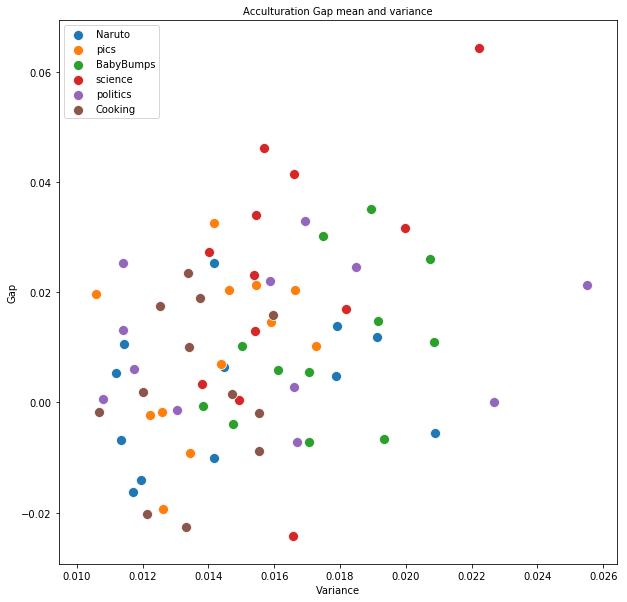

In [62]:

plt.figure(figsize=(10,10))

subs = {}
for sub in subs_acc.keys():
    subs[sub] = {}
    gap = [subs_acc[sub][m]['gap'] for m in range(1,13)]
    var = [subs_acc[sub][m]['var'] for m in range(1,13)]
    subs[sub]['gap'] = gap
    subs[sub]['var'] = var 
    ax = sns.scatterplot(x=subs[sub]['var'], y=subs[sub]['gap'], s=100 )
    
ax.set_title('Acculturation Gap mean and variance', fontsize=10)
ax.set_xlabel('Variance', fontsize=10)
ax.set_ylabel('Gap')
ax.legend(subs_acc.keys(), loc='upper left')

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


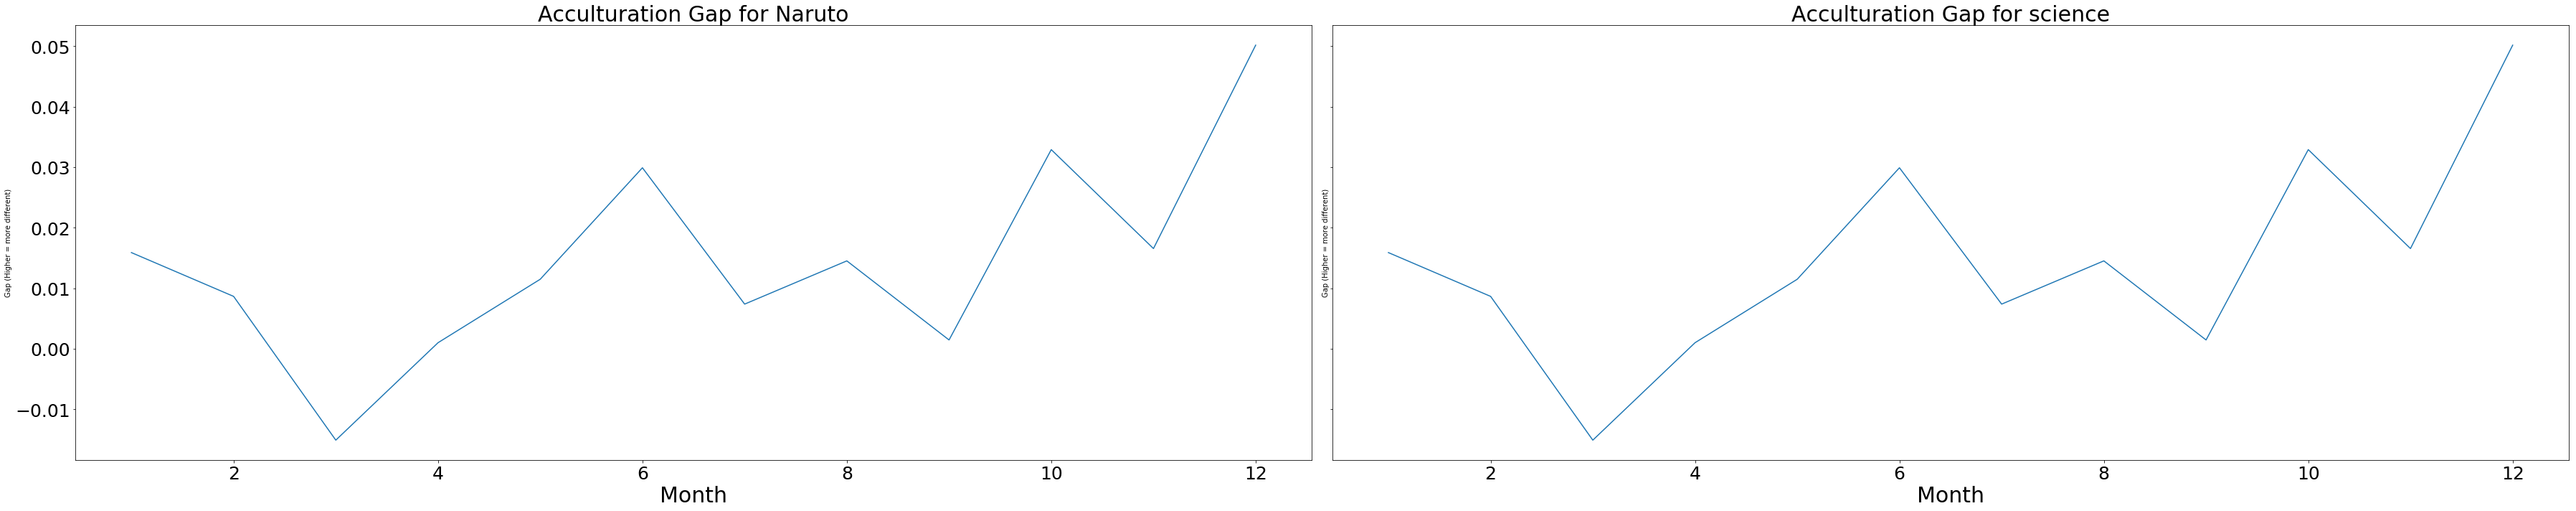

In [22]:
fig, axs = plt.subplots(1, len(subs), sharey=True, tight_layout=True)
fig.set_figheight(10)
fig.set_figwidth(50)   
for i, s in enumerate(subs):
    sns.lineplot(x=list(monthly_acc_gaps.keys()), y=[x['gap'] for x in monthly_acc_gaps.values()], ax=axs[i])
    axs[i].set_title('Acculturation Gap for ' + s, fontsize=30)
    axs[i].set_xlabel('Month', fontsize=30)
    axs[i].set_ylabel('Gap (Higher = more different)')
    axs[i].tick_params(axis='both', which='major', labelsize=25)

In [ ]:
subs_acc

In [23]:
subs_acc

{'Naruto': {1: {'gap': 0.0158906868097042, 'var': 0.016197649858166147},
  2: {'gap': 0.008654285072434384, 'var': 0.01349497335570637},
  3: {'gap': -0.015103534709686091, 'var': 0.012940202771811926},
  4: {'gap': 0.0009958964102620169, 'var': 0.014141711392373014},
  5: {'gap': 0.011483408530466055, 'var': 0.018144701652350978},
  6: {'gap': 0.02990470933375386, 'var': 0.014474960357093359},
  7: {'gap': 0.007375879824401764, 'var': 0.01070487334163013},
  8: {'gap': 0.014520506543433705, 'var': 0.015629640286307523},
  9: {'gap': 0.0014515018146755772, 'var': 0.012146395889624816},
  10: {'gap': 0.03290278915665397, 'var': 0.014982262018295387},
  11: {'gap': 0.016557177873576922, 'var': 0.013122524315323757},
  12: {'gap': 0.050167129094469486, 'var': 0.013957615337988234}}}

In [19]:
print({sub: (np.mean(list(subs_acc[sub].values())), np.std(list(subs_acc[sub].values())))  for sub in subs_acc})
print(subs_acc)

{'Naruto': (0.009812919629818265, 0.011783218215086197),
 'pics': (0.011975251710566388, 0.014269749078606859),
 'BabyBumps': (0.015155244537346171, 0.01642138988233485),
 'science': (0.0236430737783466, 0.014923287949660349),
 'politics': (0.0032399961065252805, 0.012531621295684102),
 'Cooking': (0.010342170270233224, 0.01081812579817707)}

In [9]:
### function to return df with author counts for each month
def get_author_counts(df):
    author_counts = df.groupby(['created_month'])['author'].value_counts()
    author_counts = pd.DataFrame(author_counts).reset_index(0)
    author_counts.columns = ['created_month', 'count']
    
    # added for ease of importing
    author_counts['created_month'] = author_counts['created_month'].astype(int)

    month_groups = author_counts.groupby('created_month')
    for m, g in month_groups:
        author_counts[m] = g['count']
    
    author_counts = author_counts.fillna(0)
    
    # reset index now since we don't need authors to be an index for joining counts above
    author_counts = author_counts.reset_index()
    
    # also drop all the duplicates + unnecessary cols that this made
    author_counts = author_counts.drop_duplicates(subset=['author'])
    author_counts.drop(['created_month', 'count'], axis=1, inplace=True)
    
    return author_counts



# getting number of authors who posted at least one each month
def plot_author_counts(df_author_counts, ax, sub_name):
    counts = df_author_counts[range(1,13)].apply(lambda col: col.apply(lambda row: row > 0).sum(), axis=0)
    sns.barplot(x = counts.index, y=counts, ax=ax)
    axs[i].set_title(sub + 'author counts', fontsize=30)
    axs[i].set_xticks(range(1,12))
    axs[i].tick_params(axis='both', which='major', labelsize=25)
    
    
def export_author_counts(sub_name, df, path, ext, split_size=0.3):
    print('Extracting author counts for', colored(sub_name, 'magenta'), '.....')
    author_counts = get_author_counts(df)
    ### split into test and train
    author_counts_train, author_counts_test = train_test_split(author_counts, test_size=split_size, random_state=100)
    
    # plotting both
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    plot_author_counts(author_counts_train, axs[0], sub_name+'_train')
    plot_author_counts(author_counts_test, axs[1], sub_name+'_test')
    
    fig.show()

    author_count_path_train = 'cleaned/train/2017/'+'author_counts/'+sub_name+'_author_counts_train'+ext
    author_count_path_test = 'cleaned/test/2017/'+'author_counts/'+sub_name+'_author_counts_test'+ext
    
    if EXPORTING:
        print('Exporting ', colored(author_count_path_train, 'magenta'),'.....', end='')
        author_counts_train.to_csv(author_count_path_train)
        print('Done')
        
        print('Exporting ', colored(author_count_path_test, 'magenta'),'.....', end='')
        author_counts_test.to_csv(author_count_path_test)
        print('Done')
    else:
        display(author_counts)
        
# Import comments and export author counts for a given sub NOTE THIS IS JUST FOR COMMENTS
def import_export_author_counts(sub_name, path='cleaned/', ext='_2017.csv'):
    comments_df_path = path+'sub_comments/'+sub_name+'_comments'+ext
    print('Importing', colored(comments_df_path, 'magenta'), '.....')
    df = pd.read_csv(comments_df_path)
    export_author_counts(sub_name, df, path, ext)
        



Naruto
Importing cleaned/sub_comments/Naruto_comments_2017.csv .....
Extracting author counts for Naruto .....
Exporting  cleaned/train/2017/author_counts/Naruto_author_counts_train_2017.csv .....Done
Exporting  cleaned/test/2017/author_counts/Naruto_author_counts_test_2017.csv .....Done
pics
Importing cleaned/sub_comments/pics_comments_2017.csv .....
Extracting author counts for pics .....
Exporting  cleaned/train/2017/author_counts/pics_author_counts_train_2017.csv .....Done
Exporting  cleaned/test/2017/author_counts/pics_author_counts_test_2017.csv .....Done
BabyBumps
Importing cleaned/sub_comments/BabyBumps_comments_2017.csv .....
Extracting author counts for BabyBumps .....
Exporting  cleaned/train/2017/author_counts/BabyBumps_author_counts_train_2017.csv .....Done
Exporting  cleaned/test/2017/author_counts/BabyBumps_author_counts_test_2017.csv .....Done


/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (0,4,9,10,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


science
Importing cleaned/sub_comments/science_comments_2017.csv .....
Extracting author counts for science .....
Exporting  cleaned/train/2017/author_counts/science_author_counts_train_2017.csv .....Done
Exporting  cleaned/test/2017/author_counts/science_author_counts_test_2017.csv .....Done
politics
Importing cleaned/sub_comments/politics_comments_2017.csv .....


/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (0,1,3,4,5,7,8,9,10,11,12,13,14,15,16,18,19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Extracting author counts for politics .....
Exporting  cleaned/train/2017/author_counts/politics_author_counts_train_2017.csv .....Done
Exporting  cleaned/test/2017/author_counts/politics_author_counts_test_2017.csv .....Done
Cooking
Importing 

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (0,4,8,9,10,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


cleaned/sub_comments/Cooking_comments_2017.csv .....
Extracting author counts for Cooking .....
Exporting  cleaned/train/2017/author_counts/Cooking_author_counts_train_2017.csv .....Done
Exporting  cleaned/test/2017/author_counts/Cooking_author_counts_test_2017.csv .....Done


/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


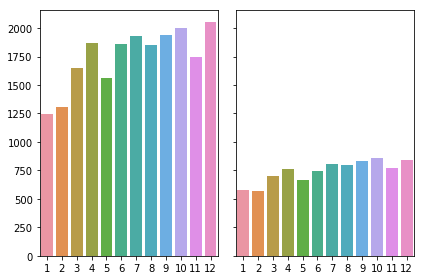

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


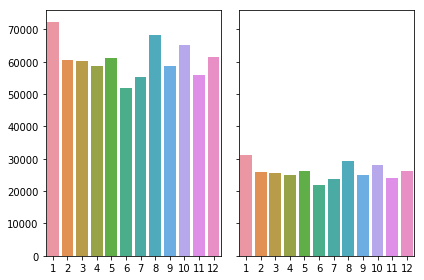

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


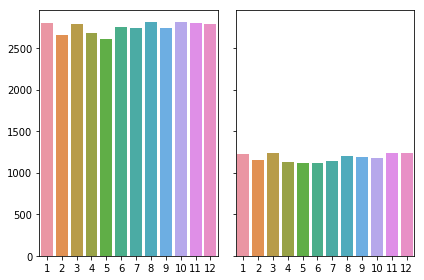

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


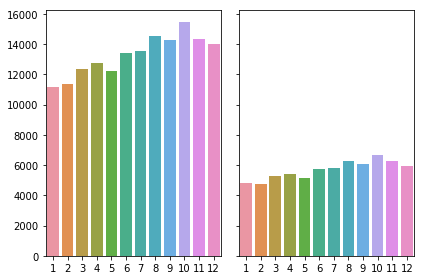

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


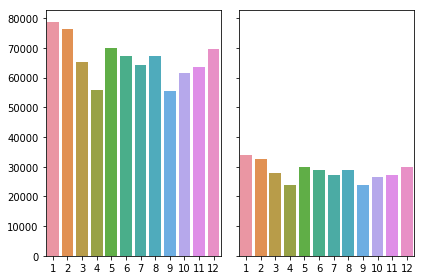

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


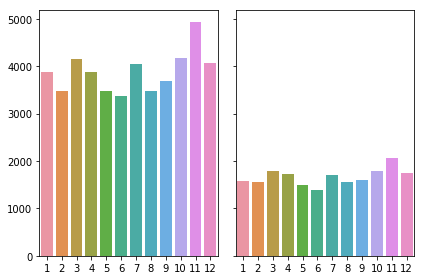

In [11]:
subs = ['Naruto', 'pics', 'BabyBumps', 'science', 'politics', 'Cooking']

EXPORTING = True
for sub in subs:
    print(sub)
    import_export_author_counts(sub)
